In [186]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyfinance.ols import RollingOLS, PandasRollingOLS
from scipy.stats import norm
import pandas_ta as ta
import math

def slope(df):
    y=df['Close'].values
    x=df['X'].values
    fit = np.polyfit(x,y,deg=1)
    n = len(x)
    m = fit[0]
    c = fit[1]
    return m

def rolling_pipe(dataframe,window):
    return pd.Series([dataframe.iloc[i-window: i].pipe(slope) 
                      if i >= window else None 
                      for i in range(1, len(dataframe)+1)],
                     index = dataframe.index)

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

window=25
ticker='^GSPC'
df=yf.download(tickers= ticker,start= '2018-1-1',end='2020-5-31',interval = "1d",
                     group_by = 'column',auto_adjust = True, prepost = True, 
                     proxy = None)
df['X'] = np.arange(len(df))
df['MA']=df['Close'].rolling(window).mean()
df['pctchg']=df['Close'].pct_change()*100
df['stdev'] = df['pctchg'].rolling(window).std()
df['slope']=df.pipe(rolling_pipe, window)
df['lrrr']=100*(window-1)*df['slope']/(df['MA']-(window-1)/2*df['slope'])
df['rsr']=df['lrrr']/(window**0.5*df['stdev'])
df['sigmoid']=df['rsr'].apply(sigmoid)
df['1']=1
df['-1']=-1
df['0']=0
#df.loc[df.index>'2019-11-21'][['Close','rsr','1','-1','0','sigmoid']].\
#df[['Close','rsr','1','-1','0','sigmoid']].\
#plot(secondary_y=['rsr','1','-1','0','sigmoid'],title=ticker,color=['black','green','orange','orange','orange','red'])

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:title={'center':'^GSPC'}, xlabel='Date'>

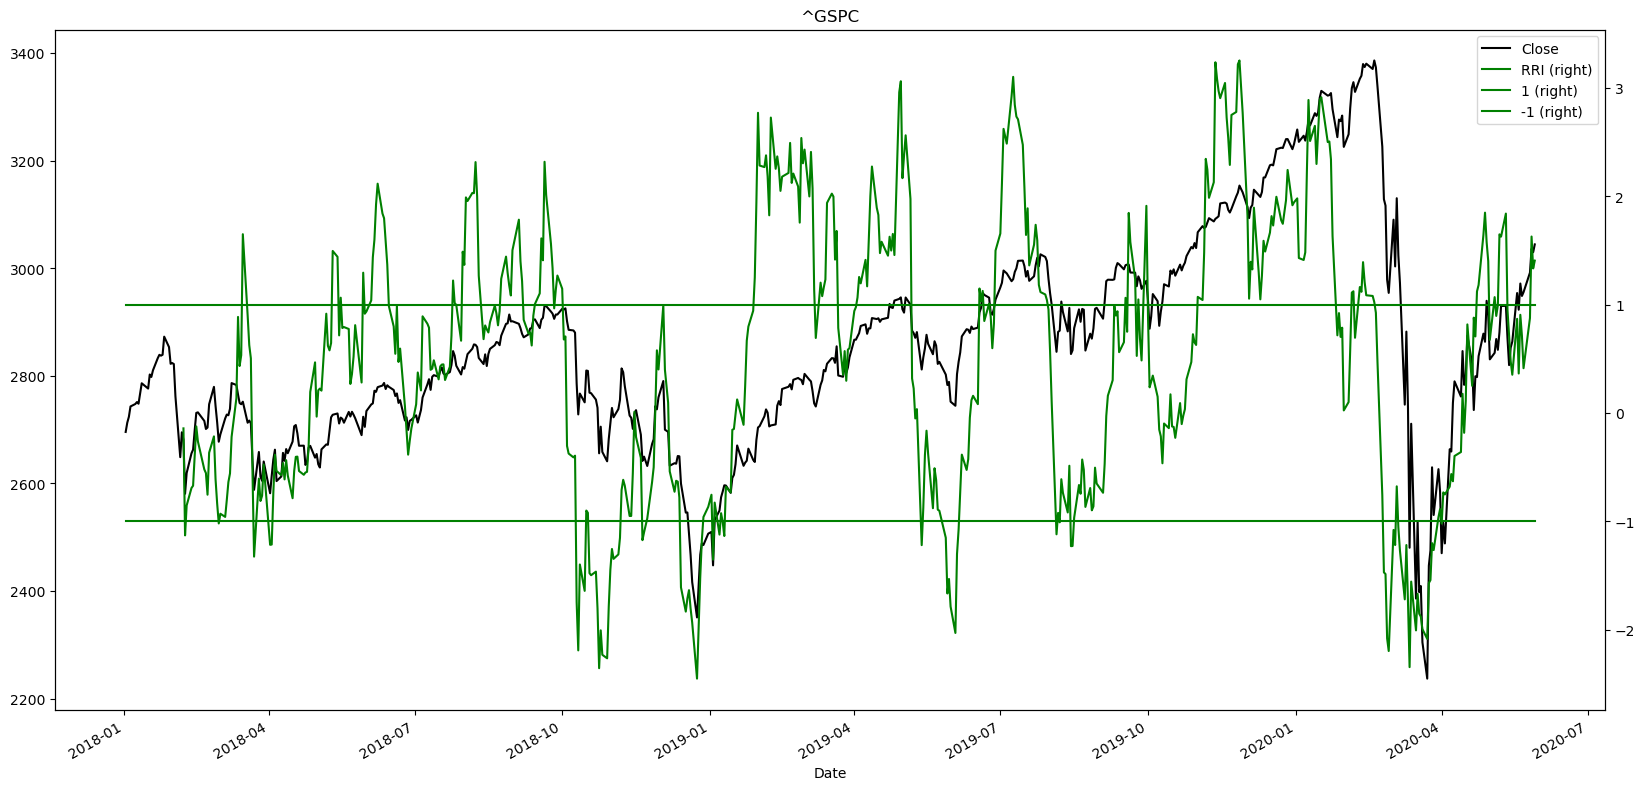

In [189]:
df['p']=df['Close'].diff().rolling(window).apply(lambda x: x.gt(0).sum())/window
df['q']=df['Close'].diff().rolling(window).apply(lambda x: x.lt(0).sum())/window
df['avggain']=df['Close'].diff().rolling(window).apply(lambda x: x[x>0].sum())/(df['p']*window)
df['avgloss']=df['Close'].diff().rolling(window).apply(lambda x: x[x<0].sum())/(df['q']*window)
df['exp_rtn']=window*(df['p']*df['avggain']+df['q']*df['avgloss'])
df['AAR']=df['Close'].diff().abs().rolling(window).mean()
df['RRI']=df['exp_rtn']/(df['AAR']*5)
df[['Close','RRI','1','-1']].plot(secondary_y=['RRI','1','-1'],title=ticker,color=['black','green','green','green'],figsize=(20,10))

In [177]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 5,
                       ):
    print(df)

                  Open        High         Low       Close      Volume    X  \
Date                                                                          
2019-10-01  2983.68994  2992.53003  2938.69995  2940.25000  3560750000    0   
2019-10-02  2924.78003  2924.78003  2874.92993  2887.61011  3914180000    1   
2019-10-03  2885.37988  2911.12988  2855.93994  2910.62988  3515130000    2   
2019-10-04  2918.56006  2953.73999  2918.56006  2952.01001  3005600000    3   
2019-10-07  2944.22998  2959.75000  2935.67993  2938.79004  2959050000    4   
2019-10-08  2920.39990  2925.46997  2892.65991  2893.06006  3370700000    5   
2019-10-09  2911.10010  2929.32007  2907.40991  2919.39990  2735350000    6   
2019-10-10  2918.55005  2948.45996  2917.12012  2938.12988  3234400000    7   
2019-10-11  2963.07007  2993.28003  2963.07007  2970.27002  3581320000    8   
2019-10-14  2965.81006  2972.84009  2962.93994  2966.14990  2559270000    9   
2019-10-15  2973.61011  3003.28003  2973.61011  2995